In [42]:
%cd drive/MyDrive/ML_finance/jansen

[Errno 2] No such file or directory: 'drive/MyDrive/ML_finance/jansen'
/content/drive/MyDrive/ML_finance/jansen


#PCA Risk-Factors

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib.ticker import FuncFormatter

In [14]:
idx = pd.IndexSlice


#store['us_equities/stocks'].marketcap.nlargest(500)
with pd.HDFStore('./data/assets.h5') as store:
    returns = (store['quandl/wiki/prices'])
#               .loc[idx['2010': '2018', stocks.index], 'adj_close']
#               .unstack('ticker')
#               .pct_change())

In [23]:
stocks = pd.read_csv('./data/us_equities_meta_data.csv')
stocks=stocks.set_index('ticker')

returns = (pd.read_csv('./data/wiki_prices.csv',
                 parse_dates=['date'],
                 index_col=['date', 'ticker'],
                 infer_datetime_format=True)
     .sort_index())
returns=(returns.loc[idx['2010': '2018', stocks.index], 'adj_close']
 .unstack('ticker')
 .pct_change())


In [27]:
returns = returns.clip(lower=returns.quantile(q=.025),
                       upper=returns.quantile(q=.975),
                       axis=1)

In [28]:
returns = returns.dropna(thresh=int(returns.shape[0] * .95), axis=1)
returns = returns.dropna(thresh=int(returns.shape[1] * .95))
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2100 entries, 2010-01-05 to 2018-03-27
Columns: 2019 entries, A to GNMK
dtypes: float64(2019)
memory usage: 32.4 MB


In [29]:
returns.head()

ticker,A,AAL,AAN,AAON,AAP,AAPL,AAWW,ABAX,ABC,ABCB,...,AOSL,TGTX,PLOW,SIX,EXPR,RRTS,TNAV,CPS,FAF,GNMK
date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.010863,0.064157,0.008948,-0.029015,-0.005944,0.001729,0.049025,0.000803,-0.007135,0.010944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,-0.003553,-0.041431,0.000000,-0.039670,0.008719,-0.015906,-0.041677,0.031701,-0.009455,0.020298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,-0.001297,0.029470,0.008083,0.037017,-0.000247,-0.001849,0.008284,0.000000,-0.016037,0.033156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,-0.000325,-0.019084,-0.006682,0.011899,0.003953,0.006648,0.008216,-0.003501,0.010865,0.003851,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,0.000649,-0.019455,0.015695,0.027096,-0.009843,-0.008822,0.003056,0.021077,0.011132,-0.007673,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
returns.mean(axis=1)

date
2010-01-05   -0.000793
2010-01-06   -0.000089
2010-01-07    0.007271
2010-01-08    0.005126
2010-01-11    0.000910
                ...   
2018-03-21    0.004132
2018-03-22   -0.019427
2018-03-23   -0.017994
2018-03-26    0.017900
2018-03-27   -0.013610
Length: 2100, dtype: float64

In [31]:
daily_avg = returns.mean(1)
returns = returns.apply(lambda x: x.fillna(daily_avg))

In [32]:
cov = np.cov(returns, rowvar=False)
pca = PCA(n_components='mle')
pca.fit(returns)

PCA(n_components='mle')

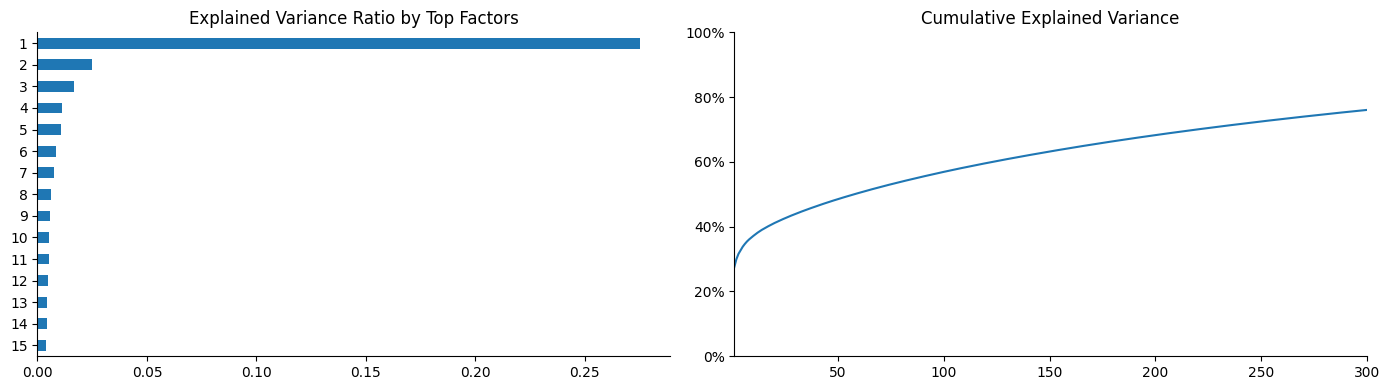

In [33]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
title = 'Explained Variance Ratio by Top Factors'
var_expl = pd.Series(pca.explained_variance_ratio_)
var_expl.index += 1
var_expl.iloc[:15].sort_values().plot.barh(title=title,
                                           ax=axes[0])
var_expl.cumsum().plot(ylim=(0, 1),
                       ax=axes[1],
                       title='Cumulative Explained Variance',
                       xlim=(1, 300))
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
sns.despine()
fig.tight_layout()

In [36]:
risk_factors = pd.DataFrame(pca.transform(returns)[:, :2],
                            columns=['Principal Component 1', 'Principal Component 2'],
                            index=returns.index)
risk_factors.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2100 entries, 2010-01-05 to 2018-03-27
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Principal Component 1  2100 non-null   float64
 1   Principal Component 2  2100 non-null   float64
dtypes: float64(2)
memory usage: 49.2 KB


In [39]:
risk_factors.head()

,Principal Component 1,Principal Component 2
date,,
2010-01-05,0.009850,0.287230
2010-01-06,0.004657,0.252657
2010-01-07,-0.319117,-0.092732
2010-01-08,-0.250252,0.091246
2010-01-11,-0.011730,-0.040263


In [38]:
risk_factors['Principal Component 1'].corr(risk_factors['Principal Component 2'])

-7.099259166545836e-15

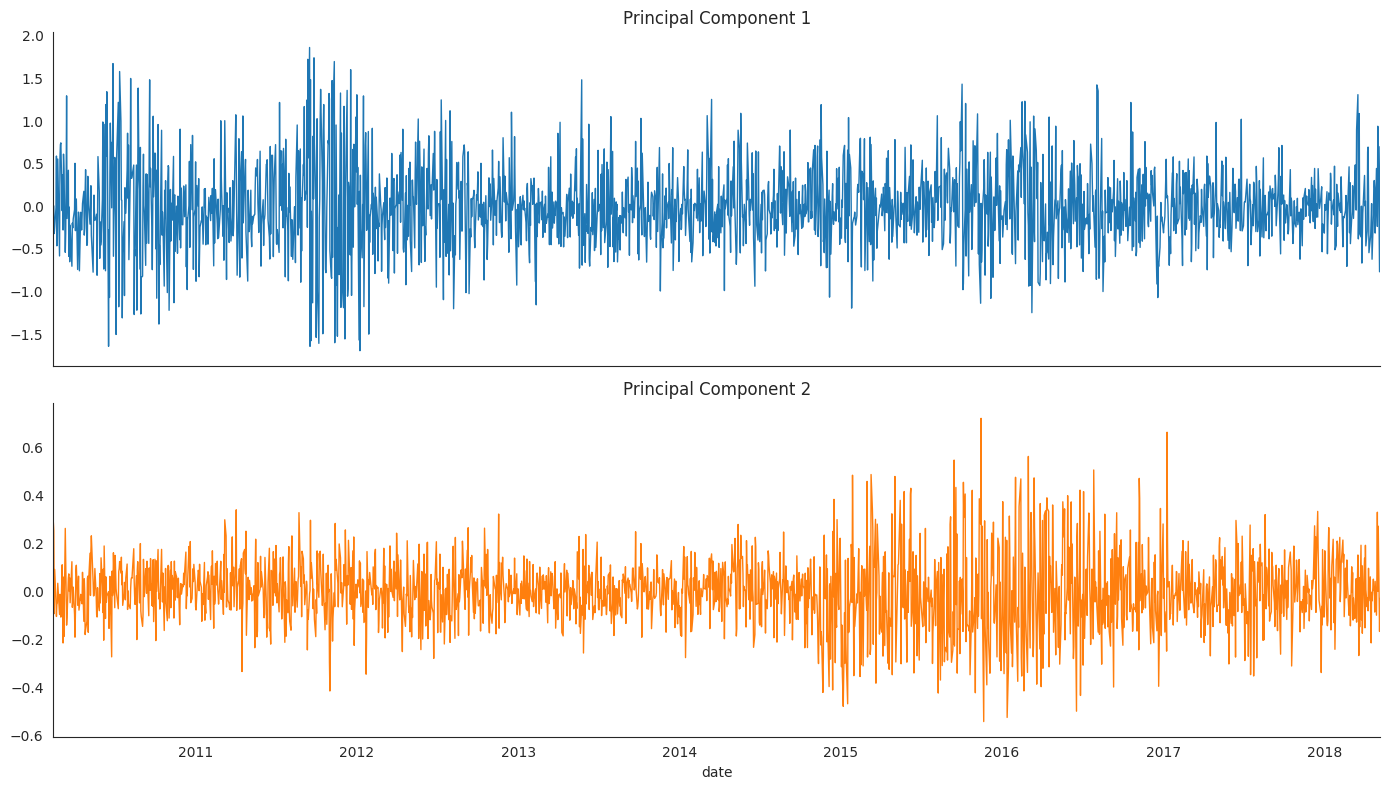

In [40]:
with sns.axes_style('white'):
    risk_factors.plot(subplots=True,
                      figsize=(14, 8),
                      title=risk_factors.columns.tolist(),
                      legend=False,
                      rot=0,
                      lw=1,
                      xlim=(risk_factors.index.min(),
                            risk_factors.index.max()))

    sns.despine()
    plt.tight_layout()

In [43]:
idx = pd.IndexSlice
with pd.HDFStore('./data/assets.h5') as store:
    returns = (store['quandl/wiki/prices']
              .loc[idx['2000': '2018', :], 'adj_close']
              .unstack('ticker')
              .pct_change())

In [47]:
from tqdm import tqdm

In [48]:
pca = PCA()
n_trials, n_samples = 100, 500
explained = np.empty(shape=(n_trials, n_samples))
for trial in tqdm(range(n_trials)):
    returns_sample = returns.sample(n=n_samples)
    returns_sample = returns_sample.dropna(thresh=int(returns_sample.shape[0] * .95), axis=1)
    returns_sample = returns_sample.dropna(thresh=int(returns_sample.shape[1] * .95))
    daily_avg = returns_sample.mean(1)
    returns_sample = returns_sample.apply(lambda x: x.fillna(daily_avg))
    pca.fit(returns_sample)
    explained[trial, :len(pca.components_)] = pca.explained_variance_ratio_

100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


In [49]:
explained = pd.DataFrame(explained, columns=list(range(1, explained.shape[1] + 1)))
explained.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 500 entries, 1 to 500
dtypes: float64(500)
memory usage: 390.8 KB


In [54]:
pc10 = explained.iloc[:, :10].stack().reset_index()
pc10.columns = ['Trial', 'Principal Component', 'Value']

In [60]:
pc10.groupby('Trial').Value.transform(np.cumsum)

0      0.734851
1      0.809369
2      0.839699
3      0.854803
4      0.869725
         ...   
995    0.581669
996    0.593597
997    0.605246
998    0.612616
999    0.618930
Name: Value, Length: 1000, dtype: float64

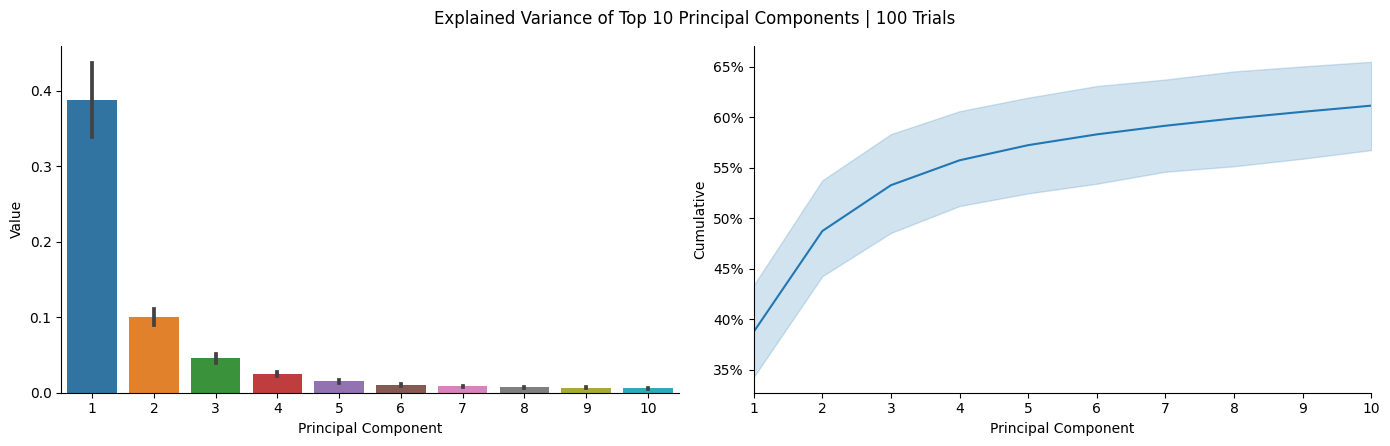

In [50]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4.5))
pc10 = explained.iloc[:, :10].stack().reset_index()
pc10.columns = ['Trial', 'Principal Component', 'Value']

pc10['Cumulative'] = pc10.groupby('Trial').Value.transform(np.cumsum)
sns.barplot(x='Principal Component', y='Value', data=pc10, ax=axes[0])
sns.lineplot(x='Principal Component', y='Cumulative', data=pc10, ax=axes[1])
axes[1].set_xlim(1, 10)
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
fig.suptitle('Explained Variance of Top 10 Principal Components | 100 Trials')
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.90)

# Eigenportfolio

In [61]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [62]:
sns.set_style('white')
np.random.seed(42)

In [105]:
stocks = pd.read_csv('./data/us_equities_meta_data.csv',index_col='ticker').marketcap.nlargest(30)


returns = (pd.read_csv('./data/wiki_prices.csv',
                 parse_dates=['date'],
                 index_col=['date', 'ticker'],
                 infer_datetime_format=True)
     .sort_index())

In [106]:
returns = (returns
               .loc[idx['2010': '2018', stocks.index], 'adj_close']
               .unstack('ticker')
               .pct_change())

In [ ]:
returns = returns.dropna(thresh=int(returns.shape[0] * .95), axis=1)
returns = returns.dropna(thresh=int(returns.shape[1] * .95))
returns.info()

In [108]:
normed_returns = scale(returns
                       .clip(lower=returns.quantile(q=.025),
                             upper=returns.quantile(q=.975),
                             axis=1)
                      .apply(lambda x: x.sub(x.mean()).div(x.std())))

In [117]:
stock_names=returns.columns

In [122]:
cov = pd.DataFrame(normed_returns).cov()
cov=cov.assign(idx=stock_names).set_index('idx')
cov=cov.rename(columns=dict(zip(range(len(stock_names)),stock_names)))

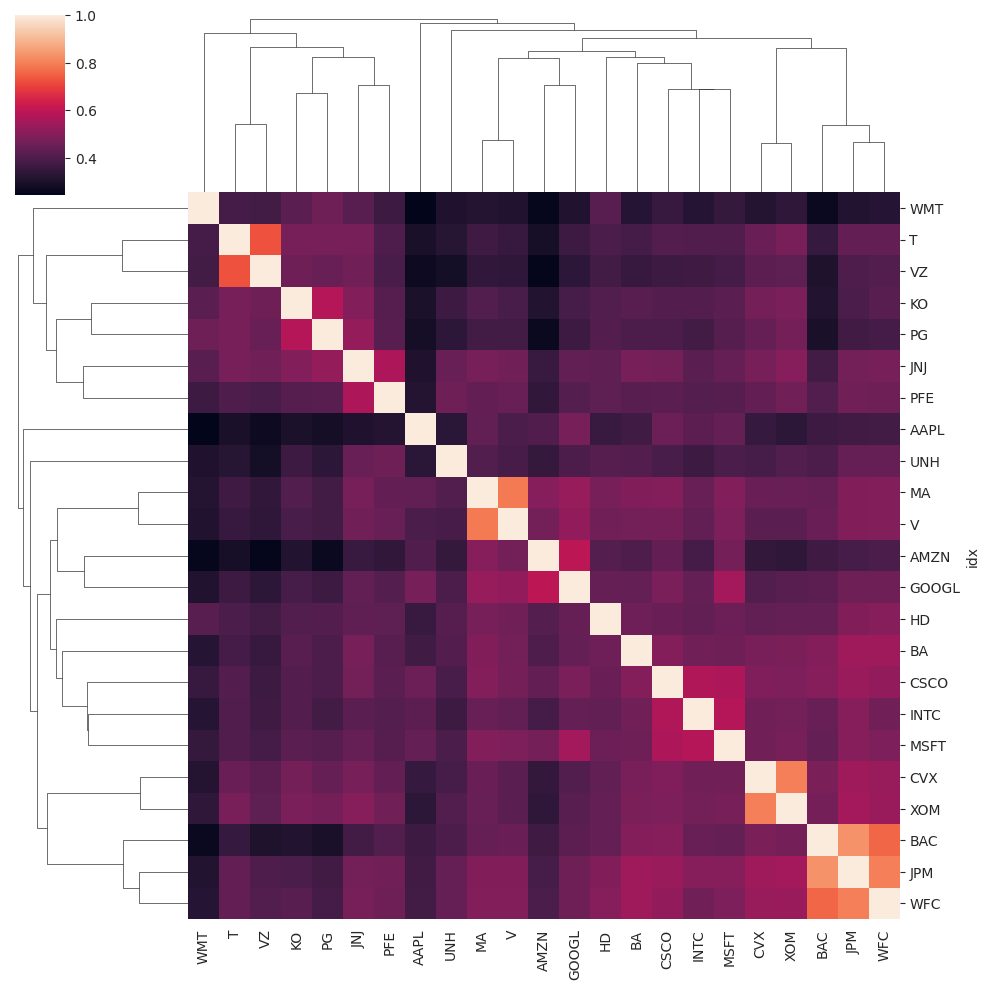

In [123]:
sns.clustermap(cov);

In [124]:
pca = PCA()
pca.fit(cov)
pd.Series(pca.explained_variance_ratio_).to_frame('Explained Variance').head().style.format('{:,.2%}'.format)

,Explained Variance
0,24.60%
1,17.17%
2,8.17%
3,7.59%
4,6.45%


In [125]:
top4 = pd.DataFrame(pca.components_[:4], columns=cov.columns)
eigen_portfolios = top4.div(top4.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range(1, 5)]

In [128]:
top4

,AAPL,AMZN,BA,BAC,CSCO,CVX,GOOGL,HD,INTC,JNJ,...,MSFT,PFE,PG,T,UNH,V,VZ,WFC,WMT,XOM
0,-0.166315,-0.220228,-0.165585,-0.385368,-0.180329,-0.059853,-0.191009,-0.068070,-0.134222,0.092950,...,-0.148790,0.012995,0.259279,0.246392,-0.075934,-0.224027,0.287323,-0.293565,0.263122,-0.036068
1,0.244330,0.314386,-0.119323,-0.322102,-0.039342,-0.335704,0.221871,-0.018529,-0.037399,-0.128608,...,0.050680,-0.092396,-0.124013,-0.235749,-0.002576,0.124399,-0.222858,-0.335771,0.026475,-0.343698
2,0.128505,-0.083756,-0.092161,0.270308,-0.108093,-0.298348,-0.157075,0.002977,-0.099083,-0.277441,...,-0.181021,-0.143219,-0.245208,-0.009322,0.099427,-0.403938,0.002415,0.140904,0.143894,-0.310593
3,-0.317085,-0.076387,0.063845,0.062672,-0.223857,-0.155559,-0.108062,0.152745,-0.317102,0.240098,...,-0.276115,0.329362,0.077191,-0.281941,0.380192,0.188865,-0.273763,0.079588,0.216611,-0.122662


In [135]:
returns.dot(eigen_portfolios.iloc[0])

date
2010-01-05    0.026886
2010-01-06    0.002644
2010-01-07    0.024154
2010-01-08    0.007153
2010-01-11   -0.013678
                ...   
2018-03-21   -0.002309
2018-03-22   -0.051462
2018-03-23   -0.035670
2018-03-26    0.059195
2018-03-27   -0.054413
Length: 2070, dtype: float64

AAPL     0.108956
AMZN     0.144275
BA       0.108477
BAC      0.252461
CSCO     0.118137
CVX      0.039211
GOOGL    0.125133
HD       0.044594
INTC     0.087931
JNJ     -0.060893
JPM      0.211008
KO      -0.136956
MA       0.148126
MSFT     0.097475
PFE     -0.008513
PG      -0.169858
T       -0.161415
UNH      0.049746
V        0.146764
VZ      -0.188230
WFC      0.192319
WMT     -0.172376
XOM      0.023629
Name: Portfolio 1, dtype: float64

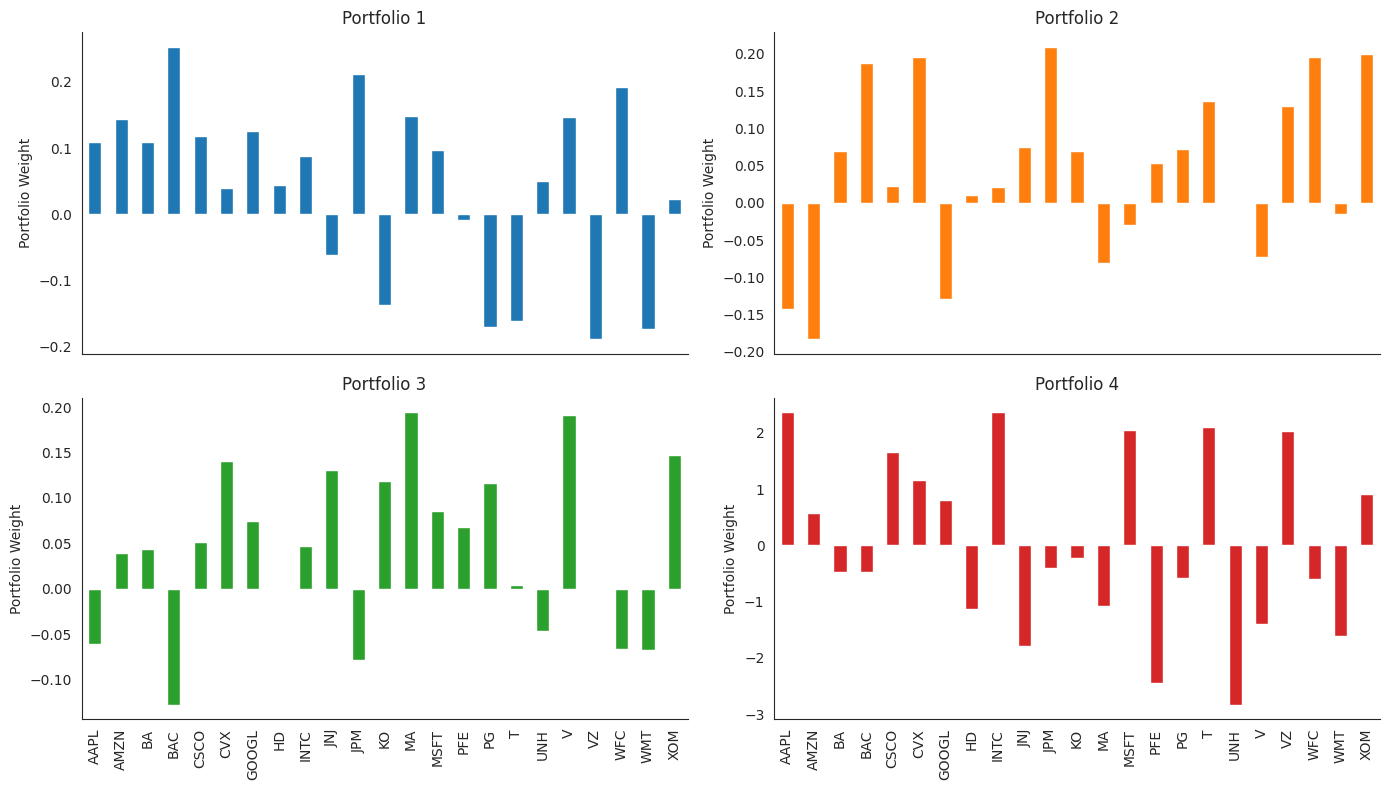

In [126]:
axes = eigen_portfolios.T.plot.bar(subplots=True,
                                   layout=(2, 2),
                                   figsize=(14, 8),
                                   legend=False)
for ax in axes.flatten():
    ax.set_ylabel('Portfolio Weight')
    ax.set_xlabel('')
sns.despine()
plt.tight_layout()

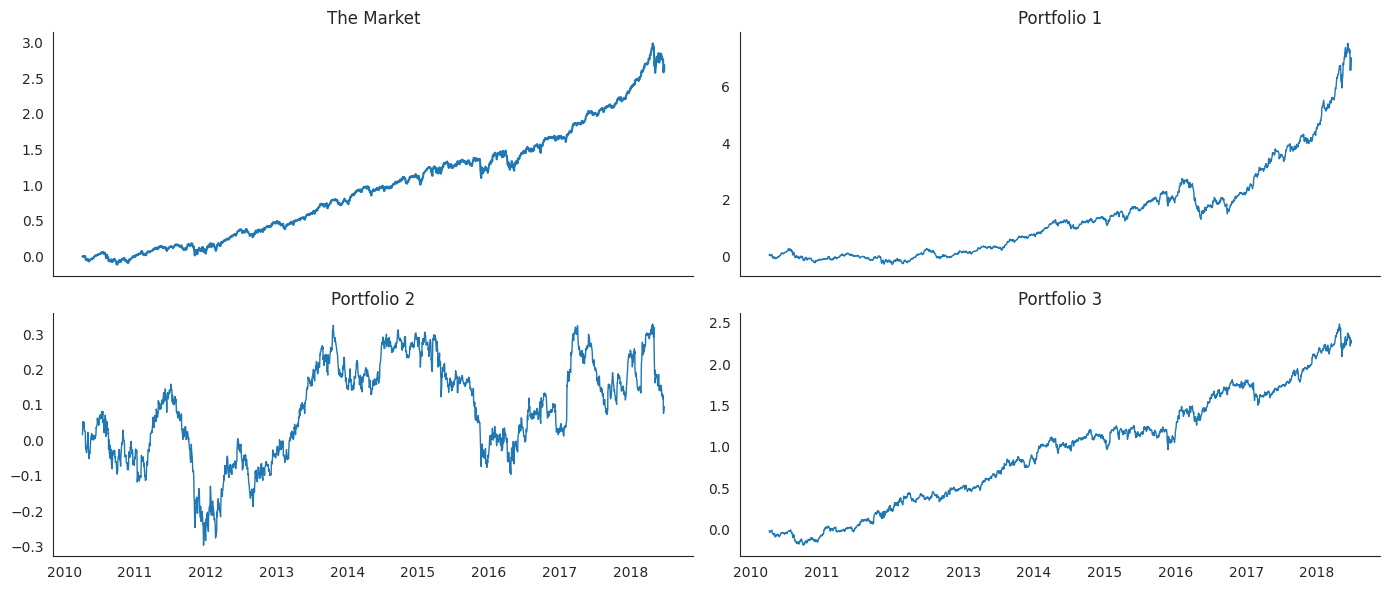

In [127]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 6), sharex=True)
axes = axes.flatten()
returns.mean(1).add(1).cumprod().sub(1).plot(title='The Market', ax=axes[0])
for i in range(3):
    rc = returns.mul(eigen_portfolios.iloc[i]).sum(1).add(1).cumprod().sub(1)
    rc.plot(title=f'Portfolio {i+1}', ax=axes[i+1], lw=1, rot=0)

for i in range(4):
    axes[i].set_xlabel('')
sns.despine()
fig.tight_layout()

# Hierarchial Risk Parity

In [136]:
%matplotlib inline
import numpy as np
import pandas as pd

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import seaborn as sns

In [137]:
sns.set_style('whitegrid')
np.random.seed(42)

In [138]:
with pd.HDFStore('./data/assets.h5') as store:
    sp500_stocks = store['sp500/stocks'].index
    prices = store['quandl/wiki/prices'].adj_close.unstack('ticker').filter(sp500_stocks)

In [139]:
start = 1988
end = 2017

In [140]:
monthly_returns = prices.loc[f'{start}':f'{end}'].resample('M').last().pct_change().dropna(how='all')
monthly_returns = monthly_returns.dropna(axis=1)
monthly_returns.columns.names = ['Ticker']
monthly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 1988-02-29 to 2017-12-31
Freq: M
Columns: 192 entries, MMM to XEL
dtypes: float64(192)
memory usage: 541.3 KB


In [141]:
def get_inverse_var_pf(cov):
    """Compute the inverse-variance portfolio"""
    ivp = 1 / np.diag(cov)
    return ivp / ivp.sum()

In [142]:
def get_distance_matrix(corr):
    """Compute distance matrix from correlation;
        0 <= d[i,j] <= 1"""
    return np.sqrt((1 - corr) / 2)

In [143]:
cov = monthly_returns.cov()
corr = monthly_returns.corr()
corr.columns.names=['Ticker']

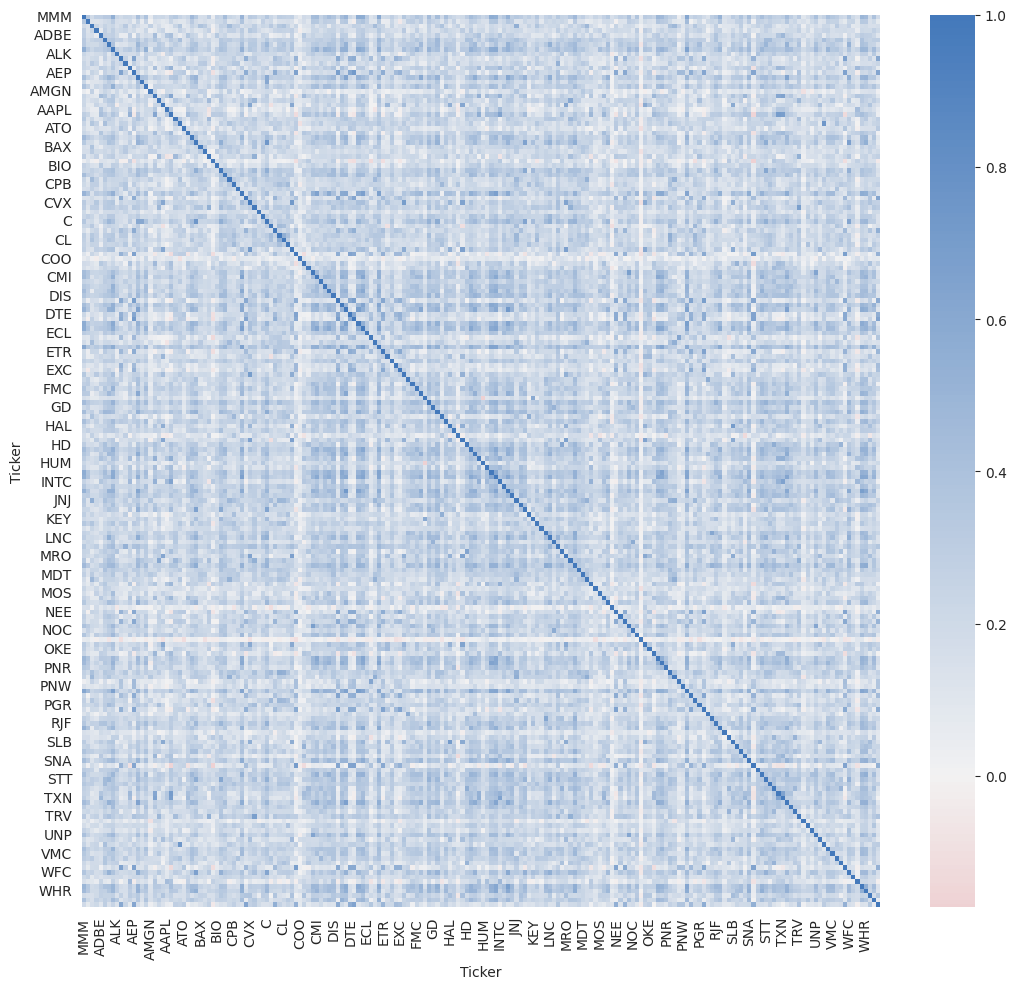

In [144]:
cmap = sns.diverging_palette(10, 250, as_cmap=True)
fig, ax = plt.subplots(figsize=(11,10))
sns.heatmap(corr, center = 0, cmap = cmap, ax=ax)
fig.tight_layout()

In [147]:
def quasi_diagonalize(link):
    """sort clustered assets by distance"""
    link = link.astype(int)
    sort_idx = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]  # idx of original items
    while sort_idx.max() >= num_items:
        sort_idx.index = list(range(0, sort_idx.shape[0] * 2, 2))  # make space
        df0 = sort_idx[sort_idx >= num_items]  # find clusters
        i = df0.index
        j = df0.values - num_items
        sort_idx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sort_idx = sort_idx.append(df0)  # item 2
        sort_idx = sort_idx.sort_index()  # re-sort
        sort_idx.index = list(range(sort_idx.shape[0]))  # re-index
    return sort_idx.tolist()

In [148]:
distance_matrix = get_distance_matrix(corr)
linkage_matrix = linkage(squareform(distance_matrix), 'single')

In [ ]:
sorted_idx

In [149]:
sorted_idx = quasi_diagonalize(linkage_matrix)

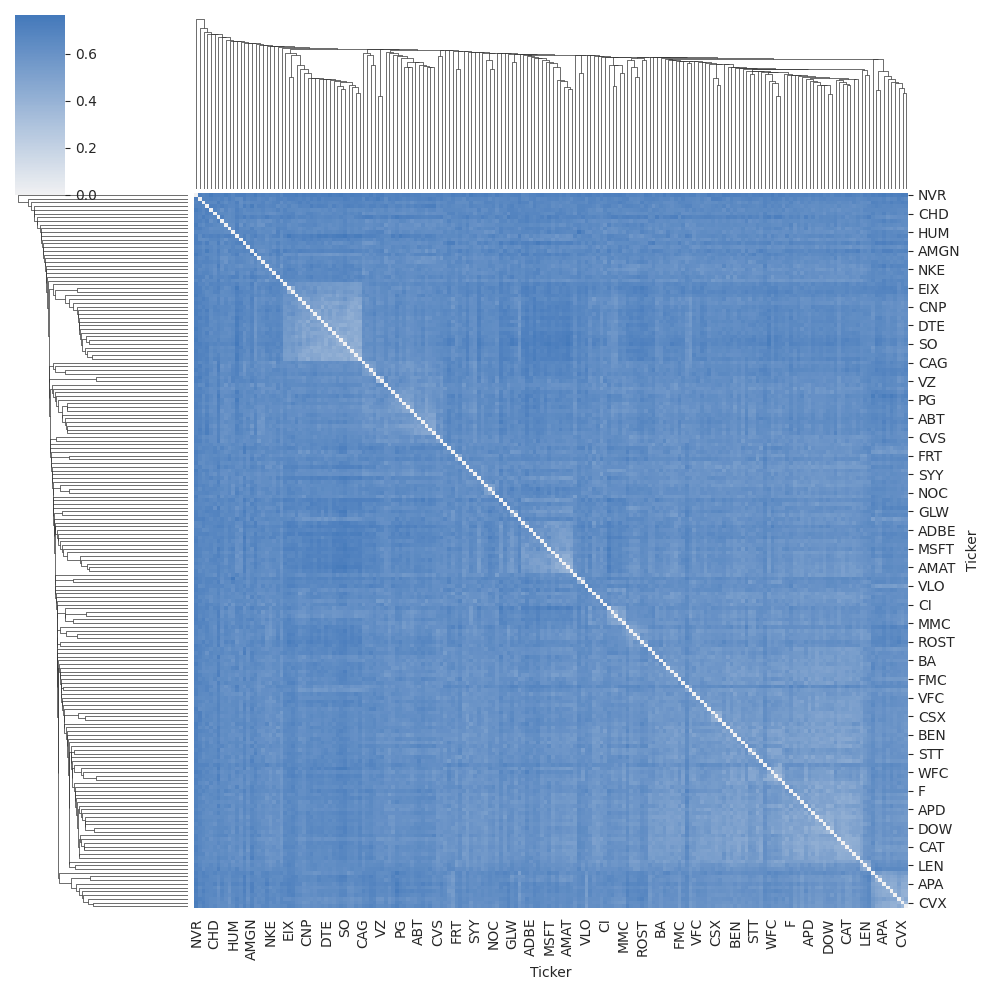

In [150]:
clustergrid = sns.clustermap(distance_matrix,
                             method='single',
                             row_linkage=linkage_matrix,
                             col_linkage=linkage_matrix,
                             cmap=cmap, center=0);

In [158]:
sorted_idx = clustergrid.dendrogram_row.reordered_ind

In [159]:
sorted_tickers = corr.index[sorted_idx].tolist()

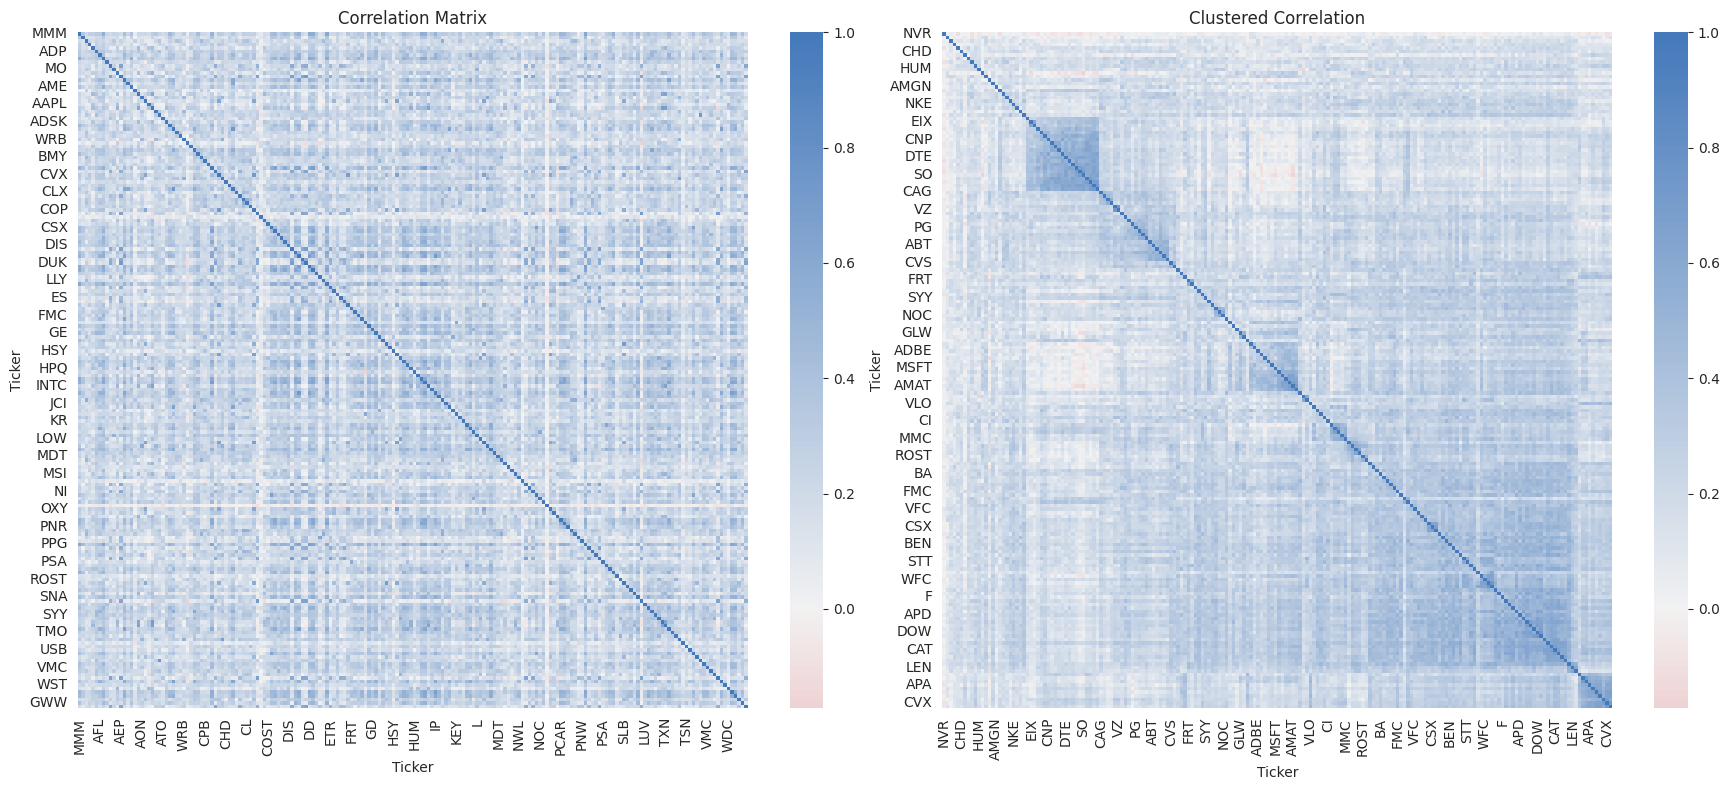

In [160]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 8))
cmap = sns.diverging_palette(10, 250, as_cmap=True)

sns.heatmap(corr, center = 0, cmap = cmap, ax=axes[0])
axes[0].set_title('Correlation Matrix')
fig.tight_layout()

clustered_assets = corr.loc[sorted_tickers, sorted_tickers]  # reorder
sns.heatmap(clustered_assets, center = 0, cmap = cmap, ax=axes[1])
axes[1].set_title('Clustered Correlation')
fig.tight_layout();

In [161]:
def get_cluster_var(cov, cluster_items):
    """Compute variance per cluster"""
    cov_ = cov.loc[cluster_items, cluster_items]  # matrix slice
    w_ = get_inverse_var_pf(cov_)
    return (w_ @ cov_ @ w_).item()

In [162]:
def get_hrp_allocation(cov, tickers):
    """Compute top-down HRP weights"""

    weights = pd.Series(1, index=tickers)
    clusters = [tickers]  # initialize one cluster with all assets

    while len(clusters) > 0:
        # run bisectional search:
        clusters = [c[start:stop] for c in clusters
                    for start, stop in ((0, int(len(c) / 2)),
                                        (int(len(c) / 2), len(c)))
                    if len(c) > 1]
        for i in range(0, len(clusters), 2):  # parse in pairs
            cluster0 = clusters[i]
            cluster1 = clusters[i + 1]

            cluster0_var = get_cluster_var(cov, cluster0)
            cluster1_var = get_cluster_var(cov, cluster1)

            weight_scaler = 1 - cluster0_var / (cluster0_var + cluster1_var)
            weights[cluster0] *= weight_scaler
            weights[cluster1] *= 1 - weight_scaler
    return weights

In [163]:
hrp_allocation = get_hrp_allocation(cov, sorted_tickers)


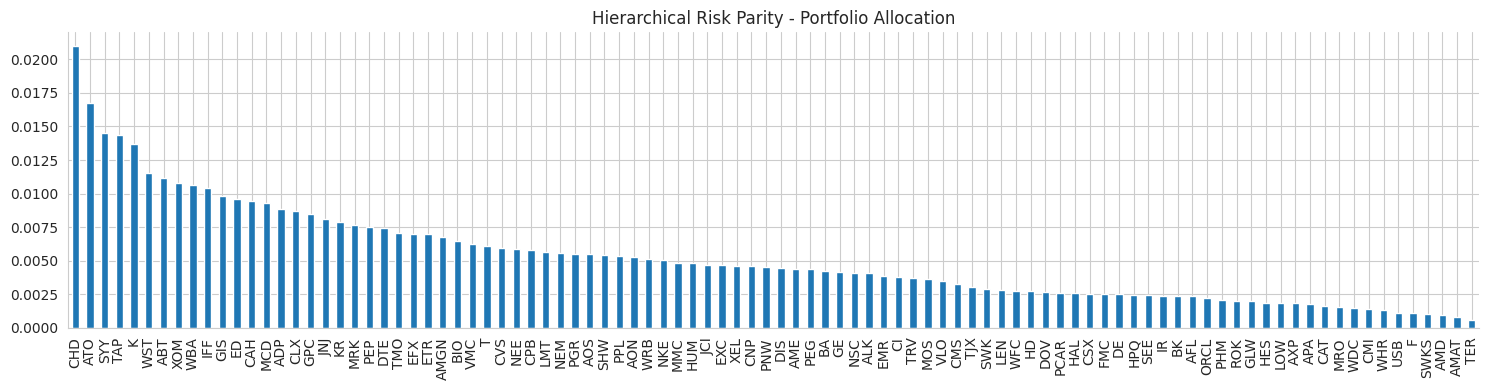

In [164]:
title = 'Hierarchical Risk Parity - Portfolio Allocation'
hrp_allocation.sort_values(ascending=False).iloc[::2].plot.bar(figsize=(15, 4),
                                                               title=title)
sns.despine()
plt.tight_layout()

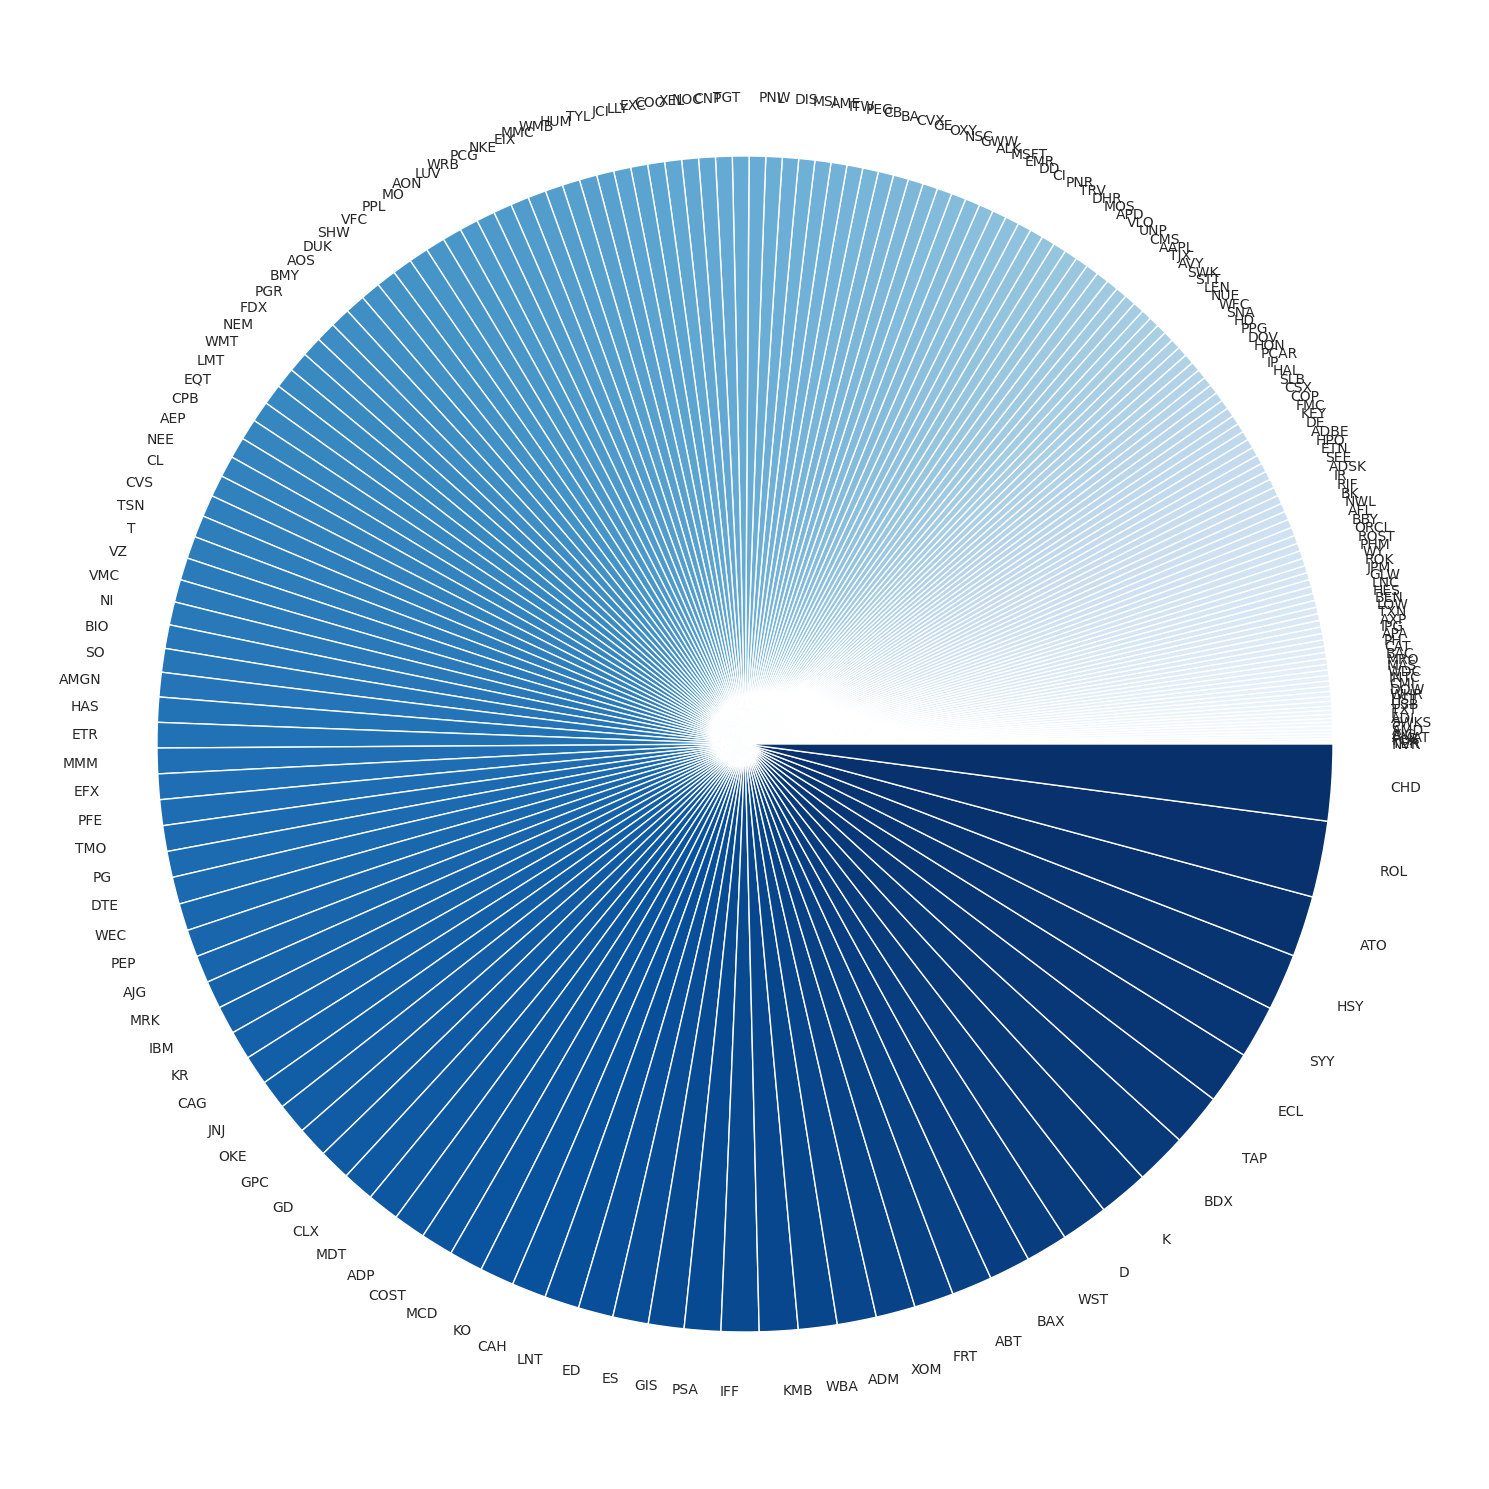

In [165]:
ax = hrp_allocation.sort_values().plot.pie(figsize=(15, 15),
                                      cmap='Blues')
ax.set_ylabel('')
plt.tight_layout();